In [19]:
# created by G Oldford, Aug-Sep 2023

# purpose: run trend analysis for each grid cell for several variables

# second attempt to detect long-term trends from model outputs
# first attempt was using inputs prepped for Ecospace

import xarray as xr
import os
import numpy as np
import pickle
import csv

import cmocean as cm

import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

import netCDF4 as nc

# load bathy and tmask for plotting
with nc.Dataset('..//data//bathymetry//bathy_salishsea_1500m_20210706.nc') as bath:
    navlon=bath.variables['nav_lon'][:]
    navlat=bath.variables['nav_lat'][:]
    bathy=bath.variables['Bathymetry'][:]
#     bathy=np.sum(mesh.variables['bathymetry'][0,:])#*mesh.variables['e3t_0'][0,:,:,:],0)
    
with nc.Dataset('..//data//mesh mask//mesh_mask_20210406.nc') as mesh:
#     print(mesh.variables)
    tmask=mesh.variables['tmask'][:]
    
grid_p = '../data/bathymetry/'
grid_f = 'bathy_salishsea_1500m_20210706.nc'
grid = xr.open_dataset(os.path.join(grid_p, grid_f), mask_and_scale=False)
    

In [20]:
def make_map(ax, grid, w_map=[-124, -123.9, 47.7, 50.6], 
             rotation=39.2, 
             par_inc=0.25,
             mer_inc=0.5, 
             fs=7,
             bg_color='#969696'
            ):
    """
    """

    # Make projection
    m = Basemap(ax=ax, 
                projection='lcc', resolution='c',
                lon_0=(w_map[1] - w_map[0]) / 2 + w_map[0] + rotation,
                lat_0=(w_map[3] - w_map[2]) / 2 + w_map[2],
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3])
    
    # Add features and labels
    x, y = m(grid.nav_lon.values, grid.nav_lat.values)
    ax.contourf(x, y, grid.Bathymetry, [-0.01, 0.01], colors='burlywood')
    ax.contour(x, y, grid.Bathymetry, [-0.01, 0.01], colors='black', linewidths=0.1)
    ax.contourf(x, y, grid.Bathymetry, [0.011,500], colors=bg_color)
#     m.drawmeridians(np.arange(-125.5, -122, mer_inc), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=fs)
    m.drawmeridians(np.arange(-125.5, -122, mer_inc), labels=[0, 0, 0, 0], linewidth=0.2, fontsize=fs)
#     m.drawparallels(np.arange(48, 51, par_inc), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=fs)
    m.drawparallels(np.arange(48, 51, par_inc), labels=[0, 0, 0, 0], linewidth=0.2, fontsize=fs)
    
    return m

def adjust_map(ax, 
               lat_bl=47.8, 
               lon_bl=-123.2, 
               lat_br=48.8, 
               lon_br=-122.28,
               lat_tl=50.3,
               lon_tl=-124.75,
               lat_bl2=48.2,
               lon_bl2=-123.5
              ):
    
    # set width using map units
    # bottom left
    x_bl,y_bl = m(lon_bl,lat_bl)
    x_br,_ = m(lon_br,lat_br)
    ax.set_xlim(x_bl, x_br)

    # top left
    x_tl, y_tl = m(lon_tl, lat_tl)
    x_bl,y_bl = m(lon_bl2,lat_bl2)
    ax.set_ylim(y_bl, y_tl)

    # fix a little path in bottom right
    lccx_TL, lccy_TL = m(-122.83, 49.4)
    lccx_BR, lccy_BR = m(-122.58, 48.7)
    lccx_BL, lccy_BL = m(-122.33, 48.7)
    lccw = lccx_BL - lccx_BR
    lcch = lccy_TL - lccy_BL

    ax.add_patch(patches.Rectangle(
                (lccx_BL, lccy_BL), lccw, lcch, 
                facecolor='burlywood', edgecolor='k',
                linewidth=0,
                zorder=0))
    
def custom_formatter(x, pos):
    return f'{x:.2f}'

def custom_formatter2(x, pos):
    return f'{x:.1f}'
    

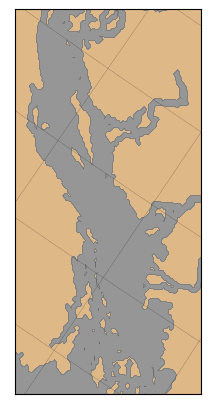

In [21]:
# test grey rotated map 
fig, ax = plt.subplots(figsize=(5,5)) #w,h
m = make_map(ax,grid,
             w_map=[-130, -115, 41, 60],
             rotation=43,
             par_inc=0.5,
             mer_inc=1
            )

adjust_map(ax)
plt.show()

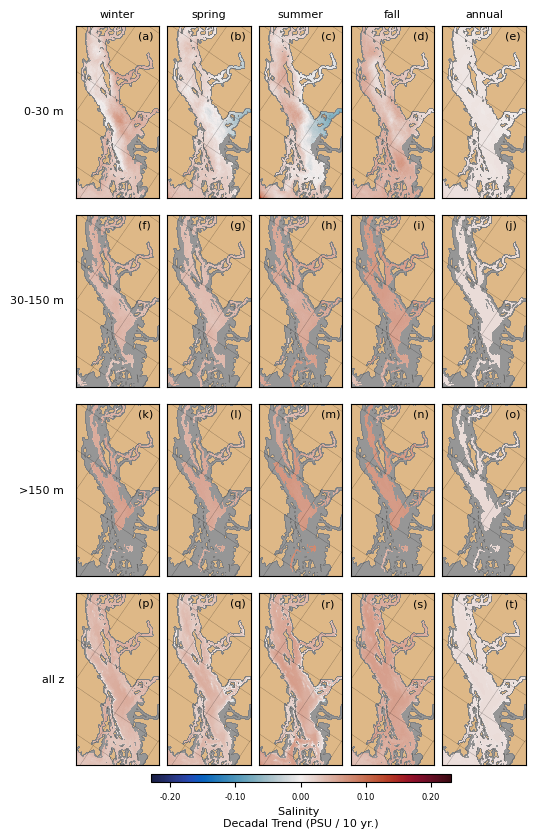

In [29]:
# plot temp 
# (already inspected others, nothing too interesting, see below)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(5, 8.5)) # w,h
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.08, top=0.95, wspace=0.1, hspace=0.1)

mask_sig = False # mask based on Kendal Tau significance thresh?
use_mesh = True # alt way to visualize

test_p = 'D:/nemo_outputs/extract_results_216/trend_output/anom_trend_frommonth/'
#test_p = 'D:/nemo_outputs/extract_results_203/trend_output/anom_trend_frommonth/'

row_labels = ['0-30 m', '30-150 m', '>150 m', 'all z']
column_labels = ['winter', 'spring', 'summer', 'fall', 'annual']
seasons = ['winter', 'spring', 'summer', 'fall', 'annual']
seasons = ['winter', 'spring', 'summer', 'fall', 'annual']
depth_groups = ["0to30m", "30to150m", "gt150m", "allz"]

variables = ['vosaline']#, 'votemper','vosaline', 'vomecrty', 'vozocrtx']#,
#variables2D = ['mldkz5', 'mldr10_1']
#labelx = f'Temperature \nDecadal Trend (°C / 10 yr.)'
labelx = f'Salinity \nDecadal Trend (PSU / 10 yr.)'
labell = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v']

num_color_bins = 7
variable_bins = {'votemper':[-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02],
                 'vosaline':[-0.03, -0.015, 0, 0.015, 0.03, 0.045]
                }

# Dictionary to store colorbar handles
colorbars = {}
var_min_max = {}

# label columns
fs1 = 8
for idx, label in enumerate(column_labels):
    ax = axes[0, idx]  # Get the first row and corresponding column index
    ax.set_title(label, fontsize=fs1)
    
# row labels
for idx, label in enumerate(row_labels):
    ax = axes[idx, 0]
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad + 3, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fs1)
    
for variable in variables:
    var_min = np.inf  # Initialize with positive infinity
    var_max = -np.inf  # Initialize with negative infinity

    for season in seasons:
        for depth_group in depth_groups:
            # Load the data for the current variable, depth group, and season
            file_name = f'anom_trend_{variable}_{depth_group}_{season}.nc'
            with nc.Dataset(os.path.join(test_p, file_name)) as test:
                slopes = test.variables['slope'][:]
            
            var_min = min(var_min, np.nanmin(slopes))
            var_max = max(var_max, np.nanmax(slopes))
            
    var_min_max[variable] = (var_min, var_max)

for depth_idx, depth_group in enumerate(depth_groups):
    for var_idx, variable in enumerate(variables):
        for season_idx, season in enumerate(seasons):
#             print('season ', season)
#             print('variable ', variable)
#             print('depth ', depth_group)
#             print('row ', depth_idx)
#             print('col ', season_idx + (len(seasons) * var_idx)
            ax = axes[depth_idx, season_idx + (len(seasons) * var_idx)]
            
            # Load the data for the current variable, depth group, and season
            file_name = f'anom_trend_{variable}_{depth_group}_{season}.nc'
            with nc.Dataset(os.path.join(test_p, file_name)) as test:
                navlon = test.variables['nav_lon'][:]
                navlat = test.variables['nav_lat'][:]
                slopes = test.variables['slope'][:]
                sig_tf = test.variables['sig_tf'][:]
            
            m = make_map(ax, grid,
                         w_map=[-130, -115, 41, 60],
                         rotation=43,
                         par_inc=0.5,
                         mer_inc=1
                        )
            adjust_map(ax)
            
            # apply masks
            slopes = np.ma.masked_where(tmask[0,0,:] == 0, slopes)
            if mask_sig == True: # mask out insignificant trend?
                slopes = np.ma.masked_where(sig_tf == 0, slopes)
            slopes = slopes * 10 # scale to decadal
            
            if depth_group == '0to30m':
                slopes = np.ma.masked_where(bathy < 20, slopes)
            elif depth_group == '30to150m':
                slopes = np.ma.masked_where(bathy < 150, slopes)
            elif depth_group == 'gt150m':
                slopes = np.ma.masked_where(bathy < 200, slopes)
            elif depth_group == 'allz':
                slopes = np.ma.masked_where(bathy < 30, slopes)

            x, y = m(navlon, navlat)
            
            # for data exploration (bins, colors hardcoded after doing it as below)
            min_val = var_min_max[variable][0] * 0.6
            max_val = var_min_max[variable][1] * 0.6
#             c = m.contourf(x, y, slopes, 
#                            cmap=cm.cm.balance, 
#                            #cmap=cmap,
#                            levels=np.linspace(min_val * 10, max_val * 10, num_color_bins)
#                           )

            if use_mesh:
                c = m.pcolormesh(x, y, slopes, cmap='cmo.balance', shading='auto',
                               vmin=-max_val*10, vmax=max_val*10)
            else:

                boundaries = variable_bins[variable]
                boundaries = np.multiply(boundaries, 10) # scale to decadal
                # the data are not centred on zero
                # so need to manually fiddle
                cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
                c = m.contourf(x, y, slopes, # decadal scaling 
                               cmap=cmap_balance, 
                               #cmap=cmap,
                               levels=boundaries
                              )
            
            if var_idx not in colorbars and season_idx == len(seasons) - 1:
                # Create a colorbar only once per variable
                strtx_wrt_panel = 0.2 
                width_wrt_panel = 0.6
                btm_y=0.06
                hght = 0.01
                orientation = 'horizontal'
                
                cax = plt.axes([strtx_wrt_panel, btm_y, width_wrt_panel, hght]) #,left,bottom, width, height
                colorbars[var_idx] = plt.colorbar(c, cax=cax, 
                                                  orientation=orientation, 
                                                  format=ticker.FuncFormatter(custom_formatter))
                colorbars[var_idx].set_label(labelx, fontsize=8)  # Customize the label as needed
                colorbars[var_idx].ax.tick_params(labelsize=6)
            
            l_idx = season_idx + len(seasons) * depth_idx
            ax.text(0.75, 0.97, '(' + labell[l_idx] + ')', ha='left', va='top', fontsize=8, transform=ax.transAxes)

# plt.tight_layout()
plt.show()


In [8]:
var_min_max

{'votemper': (-0.006568665842878829, 0.03711766140900115)}

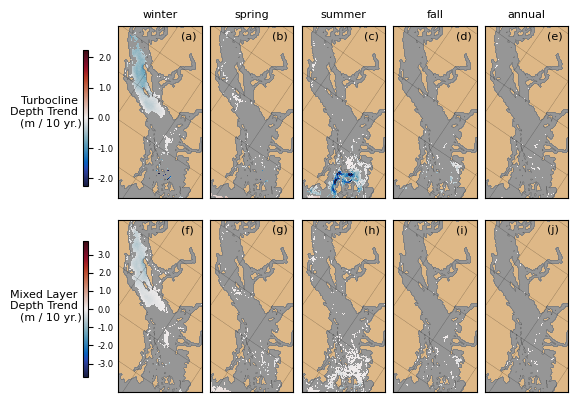

In [16]:
# 2D analysis

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(5, 4.25)) # w,h
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.08, top=0.95, wspace=0.1, hspace=0.1)

mask_sig = True # mask based on Kendal Tau significance thresh?
use_mesh = True # alt way to visualize
decadal = True # multiply slope by 10

#test_p = 'D:/temp_nemo/trend_output/anom_trend_seasavg/'
#test_p = 'D:/temp_nemo/trend_output/anom_trend_frommonth/' # months will have higher p vals
test_p = 'D:/nemo_outputs/extract_results_216/trend_output/anom_trend_frommonth/'
#test_p = 'D:/temp_nemo/trend_output/anom_trend_fromyear/'

column_labels = ['winter', 'spring', 'summer', 'fall', 'annual']
seasons = ['winter', 'spring', 'summer', 'fall', 'annual']

variables2D = ['mldkz5', 'mldr10_1']
row_labels = ['Turbocline \nDepth Trend \n(m / 10 yr.)',
              'Mixed Layer \nDepth Trend \n(m / 10 yr.)']
labelx = f'Decadal Trend (m / 10 yr)'
labell = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v']

# Dictionary to store colorbar handles
colorbars = {}
var_min_max = {}

# label columns
fs1 = 8
for idx, label in enumerate(column_labels):
    ax = axes[0, idx]  # Get the first row and corresponding column index
    ax.set_title(label, fontsize=fs1)
    
# row labels
for idx, label in enumerate(row_labels):
    ax = axes[idx, 0]
    ax.annotate(label, xy=(-0.2, 0.5), xytext=(-ax.yaxis.labelpad - 15, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fs1)
    
for variable in variables2D:
    var_min = np.inf  # Initialize with positive infinity
    var_max = -np.inf  # Initialize with negative infinity

    for season in seasons:
        # Load the data for the current variable, depth group, and season
        file_name = f'anom_trend_{variable}_{season}.nc'
        with nc.Dataset(os.path.join(test_p, file_name)) as test:
            slopes = test.variables['slope'][:]

        var_min = min(var_min, np.nanmin(slopes))
        var_max = max(var_max, np.nanmax(slopes))
            
    var_min_max[variable] = (var_min, var_max)


for var_idx, variable in enumerate(variables2D):
    for season_idx, season in enumerate(seasons):
#             print('season ', season)
#             print('variable ', variable)
#             print('depth ', depth_group)
#             print('row ', depth_idx)
#             print('col ', season_idx + (len(seasons) * var_idx)
        ax = axes[var_idx, season_idx]

        # Load the data for the current variable, depth group, and season
        file_name = f'anom_trend_{variable}_{season}.nc'
        with nc.Dataset(os.path.join(test_p, file_name)) as test:
            navlon = test.variables['nav_lon'][:]
            navlat = test.variables['nav_lat'][:]
            slopes = test.variables['slope'][:]
            sig_tf = test.variables['sig_tf'][:]

        m = make_map(ax, grid,
                     w_map=[-130, -115, 41, 60],
                     rotation=43,
                     par_inc=0.5,
                     mer_inc=1
                    )
        adjust_map(ax)

        # apply necessary masks
        slopes = np.ma.masked_where(tmask[0,0,:] == 0, slopes)
        if mask_sig == True: # mask out insignificant trend?
            slopes = np.ma.masked_where(sig_tf == 0, slopes)

        x, y = m(navlon, navlat)

        # for data exploration (bins, colors hardcoded after doing it as below)
        min_val = var_min_max[variable][0]
        max_val = var_min_max[variable][1]
        
        if decadal:
            min_val *= 10
            max_val *= 10
            slopes *= 10
#             c = m.contourf(x, y, slopes, 
#                            cmap=cm.cm.balance, 
#                            #cmap=cmap,
#                            levels=np.linspace(min_val * 10, max_val * 10, num_color_bins)
#                           )

        if use_mesh:
            c = m.pcolormesh(x, y, slopes, cmap='cmo.balance', shading='auto',
                           vmin=-max_val, vmax=max_val)
        else:

            boundaries = variable_bins[variable]
            boundaries = np.multiply(boundaries, 10) # scale to decadal
            # the data are not centred on zero
            # so need to manually fiddle
            cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
            c = m.contourf(x, y, slopes, # decadal scaling 
                           cmap=cmap_balance, 
                           #cmap=cmap,
                           levels=boundaries
                          )
            
#         if season == 'summer':
#             print(np.nanmax(slopes))
#             print(np.nanmin(slopes))

        # show colorbar, drawn from last plot (assumes all have same scale)
#         if var_idx not in colorbars and season_idx == len(seasons) - 1:
        if season_idx == len(seasons) - 1:
            # Create a colorbar only once per variable
            strtx_wrt_panel = -0.02 
            width_wrt_panel = 0.01
            if var_idx == 0:
                btm_y=0.57
            else:
                btm_y=0.12
            hght = 0.32
            orientation = 'vertical'

            cax = plt.axes([strtx_wrt_panel, btm_y, width_wrt_panel, hght]) #,left,bottom, width, height
            colorbars[var_idx] = plt.colorbar(c, cax=cax, 
                                              orientation=orientation, 
                                              format=ticker.FuncFormatter(custom_formatter2))
            colorbars[var_idx].set_label(labelx, fontsize=8)  # Customize the label as needed
            colorbars[var_idx].ax.tick_params(labelsize=6)
            colorbars[var_idx].set_label('')
            
        l_idx = season_idx + var_idx * (len(seasons))
        ax.text(0.75, 0.97, '(' + labell[l_idx] + ')', ha='left', va='top', 
                fontsize=8, transform=ax.transAxes)

# plt.tight_layout()
plt.show()

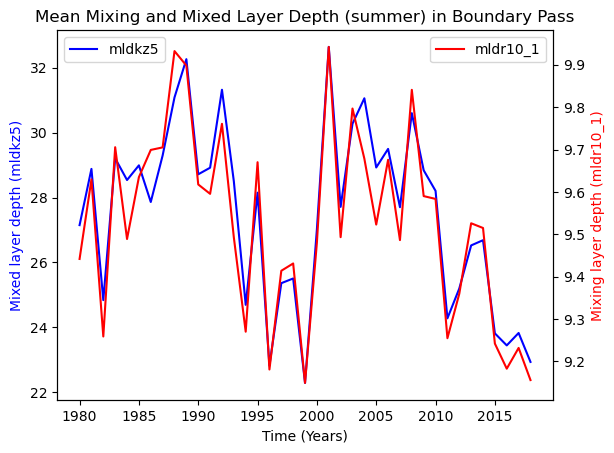

In [204]:
# plot of turbocline in SGI and NGS - mean depths
import os
import numpy as np
from netCDF4 import Dataset
import yaml
from shapely.geometry import Polygon
from shapely.geometry import Point
import xarray as xr

# Directory containing NetCDF files
weekly_p = 'D:/temp_nemo/trend_output/weekly_avg/'
test_p = 'D:/nemo_outputs/extract_results_216/trend_output/anom_trend_frommonth/'
domain_p = '../data/evaluation/'

# List of variable names and years
variables = ['mldkz5', 'mldr10_1']
years = np.arange(1980, 2019, 1)



# Load polygon coordinates from 'analysis_domains.yml'
domains_f = os.path.join(domain_p, 'analysis_domains.yml')
with open(domains_f, 'r') as yaml_file:
    domains = yaml.safe_load(yaml_file)

# Define the bounding box polygon from the coordinates
polygon_coords = domains['polygon_coords']['GO']
polygon_coords = [coord[::-1] for coord in polygon_coords]
polygon = Polygon(polygon_coords)

# Initialize dictionaries to store average values for each variable
avg_values = {var: {} for var in variables}

# Loop through the variables
for var_idx, variable in enumerate(variables):
    for year_idx, year in enumerate(years):
        # Construct the file path
        file_name = f'weekly_avg_{variable}_{year}.nc'
        file_path = os.path.join(weekly_p, file_name)
    
        
        # Check if the file exists
        if os.path.exists(file_path):
            
            if var_idx == 0 and year_idx == 0:
                # use nc instead of xarray (faster) for spatial mask
                with Dataset(file_path, 'r') as nc_file:
                    # Read latitude, longitude, and data variables
                    nav_lat = nc_file.variables['nav_lat'][:]
                    nav_lon = nc_file.variables['nav_lon'][:]
                    
                # Initialize a mask to select cells within the polygon
                cell_mask = np.zeros(nav_lat.shape, dtype=bool) 
                # Loop through all grid points
                for i in range(nav_lat.shape[0]):
                    for j in range(nav_lat.shape[1]):
                        # Check if the point (lon, lat) is within the polygon
                        point = Point(nav_lon[i, j], nav_lat[i, j])
                        if polygon.contains(point):
                            cell_mask[i, j] = True
            
            # use xarray - not sure needed
            ds = xr.open_dataset(file_path)
            # temporal mask (summer)
            seasonal_data = ds[variable].where(ds['time_counter.month'].isin([6, 7, 8]), drop=True)

            # get cells in domain (spatial mask)
            selected_data = np.where(cell_mask, seasonal_data, np.nan)
#             weekly_avg = np.nanmean(selected_data, axis=(1, 2))
            annual_avg = np.nanmean(selected_data)
    
            # can use np.nanargmax to get index of cell with largest trend

            # Store the weekly average values in the dictionary
            avg_values[variable][year] = annual_avg

            ds.close()
        else:
            print(f"File not found: {file_name}")

# Print the average values for each variable and year
# for variable, values in avg_values.items():
#     print(f"Variable: {variable}")
#     for year, avg_value in values.items():
#         print(f"Year {year}: Average Value = {avg_value}")

import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Create a twin axis for the secondary y-axis
ax2 = ax.twinx()

# Loop through the variables
for idx, variable in enumerate(variables):
    # Initialize lists to store time and variable values
    time_values = []
    variable_values = []

    # Loop through the years
    for year in years:
        # Extract the weekly average values for the current variable and year
        annual_avg = avg_values[variable][year]

        # Append the year to the time values for each week
        time_values.extend([year])

        # Append the weekly average values to the variable values
        variable_values.extend([annual_avg])

    # Plot the time series for the current variable
    if idx == 0:
        ax.plot(time_values, variable_values, label=variable, color='blue')
    elif idx == 1:
        ax2.plot(time_values, variable_values, label=variable, color='red')
    else:
        ax.plot(time_values, variable_values, label=variable)  # Plot additional variables on the primary axis

# Set labels and legends for both axes
ax.set_xlabel('Time (Years)')
ax.set_ylabel('Mixed layer depth (' + variables[0] + ')', color='blue')
ax2.set_ylabel('Mixing layer depth (' + variables[1] + ')', color='red')
ax.set_title('Mean Mixing and Mixed Layer Depth (summer) in Boundary Pass')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


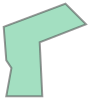

In [200]:
polygon

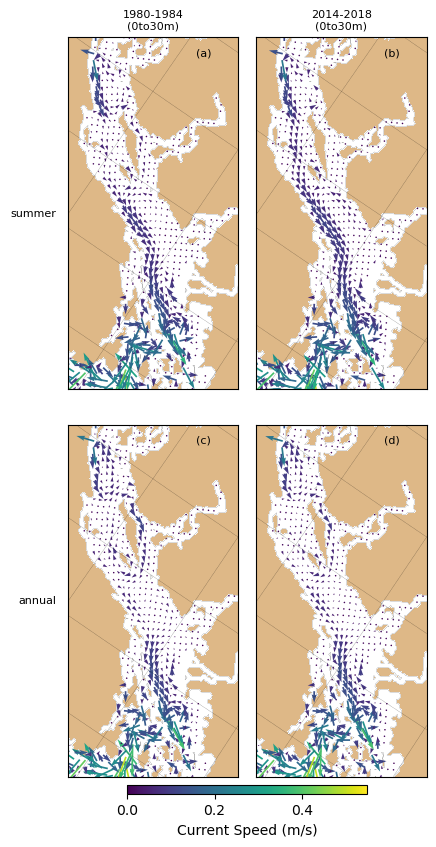

In [187]:
# plot currents
# only set up for one depth group at a time, comparison of time periods, seasons as rows
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap

# Define the directory where the NetCDF files are located
data_dir = 'D:/temp_nemo/trend_output/climatologies/'

# Define the variable dictionaries
variables = ['vomecrty', 'vozocrtx']
depth_groups = ["0to30m"]#["0to30m", "30to150m", "gt150m", "allz"]
periods = column_labels = ['1980-1984', '2014-2018']
seasons = row_labels = ['summer', 'annual']#['winter', 'spring', 'summer', 'fall', 'annual']

sqrt_tf = False

fig, axes = plt.subplots(nrows=len(seasons), ncols=2, figsize=(4, 8.5)) # w,h
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.08, top=0.95, wspace=0.1, hspace=0.1)

# label columns
fs1 = 8
for idx, label in enumerate(column_labels):
    ax = axes[0,idx]  # Get the first row and corresponding column index
    ax.set_title(label + '\n(' + depth_groups[0] + ')', fontsize=fs1)

# row labels
for idx, label in enumerate(row_labels):
    ax = axes[idx, 0]
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad + 3, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fs1)

    
min_speed = 0.0
max_speed = 0.0

# Loop through all combinations of variables, depth_groups, periods, and seasons
for depth_group in depth_groups:
    for season_idx, season in enumerate(seasons):
        for period_idx, period in enumerate(periods):
            # Construct the file name - x
            variable = 'vozocrtx'
            file_name = f"weekly_climatology_{variable}_{depth_group}_{period}_{season}.nc"
            file_path = os.path.join(data_dir, file_name)

            # Check if the file exists
            if os.path.exists(file_path):
                # Open the NetCDF file
                with Dataset(file_path, 'r') as nc_file:
                    # Read latitude, longitude, and velocity components
                    nav_lat = nc_file.variables['nav_lat'][:]
                    nav_lon = nc_file.variables['nav_lon'][:]
                    vozocrtx = nc_file.variables[variable][:]
            else:
                print(f"File not found: {file_name}")
                break
            
            # Construct the file name - y
            variable = 'vomecrty'
            file_name = f"weekly_climatology_{variable}_{depth_group}_{period}_{season}.nc"
            file_path = os.path.join(data_dir, file_name)
        
            # Check if the file exists
            if os.path.exists(file_path):
                # Open the NetCDF file
                with Dataset(file_path, 'r') as nc_file:
                    # Read latitude, longitude, and velocity components
                    nav_lat = nc_file.variables['nav_lat'][:]
                    nav_lon = nc_file.variables['nav_lon'][:]
                    vomecrty = nc_file.variables[variable][:]
            else:
                print(f"File not found: {file_name}")
                break 
            
            # Calculate the magnitude and direction of ocean currents
            speed = np.sqrt(vomecrty**2 + vozocrtx**2)
            if sqrt_tf:
                speed = np.sqrt(speed)
            angle = np.arctan2(vomecrty, vozocrtx)
            
            
            
            # plot figs
            ax = axes[season_idx,period_idx]
            m = make_map(ax, grid,
                         w_map=[-130, -115, 41, 60],
                         rotation=43,
                         par_inc=0.5,
                         mer_inc=1, 
                         bg_color='#FFFFFF'
                        )
            adjust_map(ax)
            
            adjust_map(ax, 
               lat_bl=47.8, 
               lon_bl=-123.2, 
               lat_br=48.8, 
               lon_br=-122.28,
               lat_tl=50.3,
               lon_tl=-124.75,
               lat_bl2=48.2,#48.2 or 49.2
               lon_bl2=-123.5
              )
            
            x, y = m(nav_lon, nav_lat)
            x_com, y_com = m(vozocrtx, vomecrty)
            
            # apply masks
            vomecrty = np.ma.masked_where(tmask[0,0,:] == 0, vomecrty) 
            vozocrtx = np.ma.masked_where(tmask[0,0,:] == 0, vozocrtx)
            speed = np.ma.masked_where(tmask[0,0,:] == 0, speed)
            # bathy mask
            if depth_group == '0to30m':
                dep=20
            elif depth_group == '30to150m':
                dep = 150
            elif depth_group == 'gt150m':
                dep = 200
            elif depth_group == 'allz':
                dep = 20
            speed = np.ma.masked_where(bathy < dep, speed)
            #ax.contourf(x, y, bathy, levels=[0, dep], colors='white')
            
            min_speed = min(min_speed, np.nanmin(speed))
            max_speed = max(max_speed, np.nanmax(speed))
            
            # decimate 
            dc = 3 # 2 if big plot
            scale = 2 # 5 if big plot
            width = 0.01 # 0.004 if big plot
            q=m.quiver(x[::dc,::dc], y[::dc,::dc], 
                       vozocrtx[::dc,::dc], vomecrty[::dc,::dc], 
                       speed[::dc,::dc], 
                       scale=scale,#scale - lower val exaggerates more
                       width=width # width=0.004
                      ) 

for season_idx in range(len(seasons)):
    for period_idx in range(len(periods)):
        ax = axes[season_idx, period_idx]
        
        for im in plt.gca().get_images():
            im.set_clim(vmin=min_speed, vmax=max_speed)
            
        l_idx = period_idx + len(periods) * season_idx
        ax.text(0.75, 0.97, '(' + labell[l_idx] + ')', ha='left', va='top', fontsize=8, transform=ax.transAxes)
        
#         im = ax.get_children()[0]  # Assuming quiver plot is the first child
#         im.set_clim(vmin=min_speed, vmax=max_speed)
strtx_wrt_panel = 0.2 
width_wrt_panel = 0.6
btm_y=0.06
hght = 0.01
orientation = 'horizontal'

cax = plt.axes([strtx_wrt_panel, btm_y, width_wrt_panel, hght]) #,left,bottom, width, height
cbar = plt.colorbar(q, cax=cax, orientation=orientation)
cbar.set_label('Current Speed (m/s)')        


0.76845986

In [ ]:
# old scrap code below

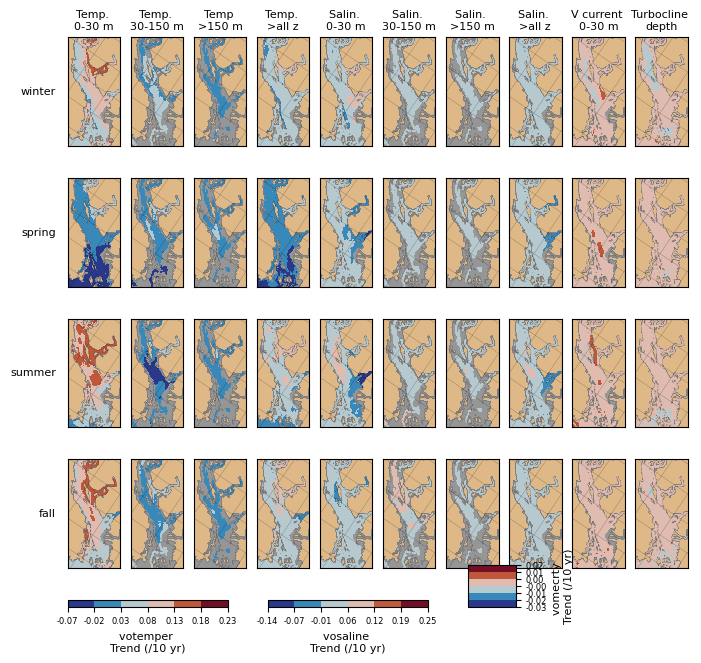

In [68]:


# Create a figure and axis objects for a 5x4 grid
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(8, 7)) # w,h

mask_sig = False

column_labels = [
    'Temp. \n0-30 m', 'Temp. \n30-150 m', 'Temp \n>150 m', 'Temp. \n>all z',
    'Salin. \n0-30 m', 'Salin. \n30-150 m', 'Salin. \n>150 m', 'Salin. \n>all z', 
    'V current \n0-30 m', 'Turbocline \ndepth'
]

row_labels = ['winter', 'spring', 'summer', 'fall']

# Dictionary to store colorbar handles
colorbars = {}
var_min_max = {} # store max min so common legend can be used

for variable in variables:
    var_min = np.inf  # Initialize with positive infinity
    var_max = -np.inf  # Initialize with negative infinity

    for season in seasons:
        for depth_group in depth_groups:
            # Load the data for the current variable, depth group, and season
            file_name = f'anom_trend_{variable}_{depth_group}_{season}.nc'
            with nc.Dataset(os.path.join(test_p, file_name)) as test:
                slopes = test.variables['slope'][:]
            
            var_min = min(var_min, np.nanmin(slopes))
            var_max = max(var_max, np.nanmax(slopes))
            
    var_min_max[variable] = (var_min, var_max)
    

# label columns
fs1 = 8
for idx, label in enumerate(column_labels):
    ax = axes[0, idx]  # Get the first row and corresponding column index
    ax.set_title(label, fontsize=fs1)
    
# row labels
for idx, label in enumerate(row_labels):
    ax = axes[idx, 0]
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad + 3, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=fs1)

# for row in axes:
#     for ax in row:
#         m = make_map(ax,grid,
#                      w_map=[-130, -115, 41, 60],
#                      rotation=43,
#                      par_inc=0.5,
#                      mer_inc=1
#                     )
#         adjust_map(ax)

var_min_max = {}

#test_p = 'D:/temp_nemo/trend_output/anom_trend_seasavg/'
test_p = 'D:/temp_nemo/trend_output/anom_trend_frommonth/'
test_p = 'D:/temp_nemo/trend_output/anom_trend_fromyear/'

seasons = ['winter', 'spring', 'summer', 'fall']
# seasons = ['winter', 'spring', 'fall']
depth_groups = ["0to30m", "30to150m", "gt150m", "allz"]
# depth_groups = ["allz"]
variables = ['votemper', 'vosaline', 'vomecrty']#, 'mldkz5', 'mldr10_1']
# variables = ['votemper', 'votemper']#, 'mldkz5', 'mldr10_1']
variables2D = ['mldkz5']

num_color_bins = 7
variable_bins = {'votemper':[-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02],
                 'vosaline':[-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
                }

def custom_formatter(x, pos):
    return f'{x:.2f}'

for variable in variables:
    var_min = np.inf  # Initialize with positive infinity
    var_max = -np.inf  # Initialize with negative infinity

    for season in seasons:
        for depth_group in depth_groups:
            # Load the data for the current variable, depth group, and season
            file_name = f'anom_trend_{variable}_{depth_group}_{season}.nc'
            with nc.Dataset(os.path.join(test_p, file_name)) as test:
                slopes = test.variables['slope'][:]
            
            var_min = min(var_min, np.nanmin(slopes))
            var_max = max(var_max, np.nanmax(slopes))
            
    var_min_max[variable] = (var_min, var_max)

# 3D variable loop
for season_idx, season in enumerate(seasons):
    for var_idx, variable in enumerate(variables):
        for depth_idx, depth_group in enumerate(depth_groups):
            # SKIP most depths for veloc 
            if variable == 'vomecrty' and depth_group != '0to30m':
                continue
        
#             print('season ', season)
#             print('variable ', variable)
#             print('depth ', depth_group)
        
#             print('row ', season_idx)
#             print('col ', depth_idx * (var_idx+1))
            ax = axes[season_idx, depth_idx + (len(depth_groups) * var_idx)]
            
            # Load the data for the current variable, depth group, and season
            file_name = f'anom_trend_{variable}_{depth_group}_{season}.nc'
            with nc.Dataset(os.path.join(test_p, file_name)) as test:
                navlon = test.variables['nav_lon'][:]
                navlat = test.variables['nav_lat'][:]
                slopes = test.variables['slope'][:]
                sig_tf = test.variables['sig_tf'][:]
            
            m = make_map(ax, grid,
                         w_map=[-130, -115, 41, 60],
                         rotation=43,
                         par_inc=0.5,
                         mer_inc=1
                        )
            adjust_map(ax)
            
            # apply necessary masks
            slopes = np.ma.masked_where(tmask[0,0,:] == 0, slopes)
            if mask_sig == True:
                slopes = np.ma.masked_where(sig_tf == 0, slopes)
            slopes = slopes * 10 # scale to decadal
            
            if depth_group == '0to30m':
                slopes = np.ma.masked_where(bathy < 20, slopes)
            elif depth_group == '30to150m':
                slopes = np.ma.masked_where(bathy < 150, slopes)
            elif depth_group == 'gt150m':
                slopes = np.ma.masked_where(bathy < 200, slopes)
            elif depth_group == 'allz':
                slopes = np.ma.masked_where(bathy < 30, slopes)

            x, y = m(navlon, navlat)
            
            # for data exploration (bins, colors hardcoded after doing it as below)
            min_val = var_min_max[variable][0] * 1.1
            max_val = var_min_max[variable][1] * 1.1
            c = m.contourf(x, y, slopes, 
                           cmap=cm.cm.balance, 
                           #cmap=cmap,
                           levels=np.linspace(min_val * 10, max_val * 10, num_color_bins)
                          )
            
#             boundaries = variable_bins[variable]
#             boundaries = np.multiply(boundaries, 10)
#             # the data are not centred on zero
#             # so need to manually fiddle
#             cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
#             c = m.contourf(x, y, slopes, 
#                            cmap=cmap_balance, 
#                            #cmap=cmap,
#                            levels=boundaries
#                           )
             
#             # this helps keep '0' values colored white
#             boundaries = np.round(np.arange(min_val, max_val, 0.004),2)
#             # create list of colors from colormap
#             cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
#             colors = list(cmap_balance(np.arange(len(boundaries))))
#             #replace first color with white
#             colors[0] = "white"
#             cmap = mpl.colors.ListedColormap(colors[:-1], "")
#             # set over-color to last color of list 
#             cmap.set_over(colors[-1])
#             norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
            
            
            if var_idx not in colorbars and season_idx == len(seasons) - 1:
                # Create a colorbar only once per variable
                # this works ok
                strtx_wrt_panel = 0.125 + 0.35 * (var_idx)
                width_wrt_panel = 0.25
                
                strtx_wrt_panel = 0.125 + 0.25 * (var_idx)
                width_wrt_panel = 0.2
                btm_y=0.06
                hght = 0.01
                
                if variable == 'vomecrty':
                    orientation = 'vertical'
                    hght = 0.06
                    width_wrt_panel = 0.06
                else:
                    orientation = 'horizontal'
                    
                cax = plt.axes([strtx_wrt_panel, btm_y, width_wrt_panel, hght]) #,left,bottom, width, height
                colorbars[var_idx] = plt.colorbar(c, cax=cax, 
                                                  orientation=orientation, 
                                                  format=ticker.FuncFormatter(custom_formatter))
                colorbars[var_idx].set_label(f'{variable} \nTrend (/10 yr)', fontsize=8)  # Customize the label as needed
                colorbars[var_idx].ax.tick_params(labelsize=6)

# divider = make_axes_locatable(axes[0, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.05)
# colorbar = plt.colorbar(c, cax=cax, orientation='horizontal')
# colorbar.set_label('Colorbar Label')  # Customize the label as needed

for variable in variables2D:
    var_min = np.inf  # Initialize with positive infinity
    var_max = -np.inf  # Initialize with negative infinity

    for season in seasons:
        # Load the data for the current variable, depth group, and season
        file_name = f'anom_trend_{variable}_{season}.nc'
        with nc.Dataset(os.path.join(test_p, file_name)) as test:
            slopes = test.variables['slope'][:]
        var_min = min(var_min, np.nanmin(slopes))
        var_max = max(var_max, np.nanmax(slopes))
    var_min_max[variable] = (var_min, var_max)
# 2D variables
# 3D variable loop
for season_idx, season in enumerate(seasons):
    for var_idx, variable in enumerate(variables2D):
        ax = axes[season_idx, var_idx + 9]
            
        # Load the data for the current variable, depth group, and season
        file_name = f'anom_trend_{variable}_{season}.nc'
        with nc.Dataset(os.path.join(test_p, file_name)) as test:
            navlon = test.variables['nav_lon'][:]
            navlat = test.variables['nav_lat'][:]
            slopes = test.variables['slope'][:]
            sig_tf = test.variables['sig_tf'][:]

        m = make_map(ax, grid,
                     w_map=[-130, -115, 41, 60],
                     rotation=43,
                     par_inc=0.5,
                     mer_inc=1
                    )
        adjust_map(ax)

        # apply necessary masks
        slopes = np.ma.masked_where(tmask[0,0,:] == 0, slopes)
        if mask_sig == True:
            slopes = np.ma.masked_where(sig_tf == 0, slopes)
        slopes = slopes * 10 # scale to decadal
            
        x, y = m(navlon, navlat)

        # for data exploration (bins, colors hardcoded after doing it as below)
        min_val = var_min_max[variable][0] * 1.1
        max_val = var_min_max[variable][1] * 1.1
        c = m.contourf(x, y, slopes, 
                       cmap=cm.cm.balance, 
                       #cmap=cmap,
                       levels=np.linspace(min_val * 10, max_val * 10, num_color_bins)
                      )
        
# plt.tight_layout
plt.show() 

In [5]:
ex_f = 'SalishSea1500-RUN203_1d_grid_T_y2017m07.nc'
ex_p = '../data/output/RUN203/'

In [114]:
variable_bins = {'votemper':[-0.0075, -0.0025, 0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275],
                 'vosaline':[-0.018, -0.012, -0.006, 0.006, 0.012, 0.018, 0.024, 0.031]
                }
variable = 'votemper'
boundaries = variable_bins[variable]
cm.cm.balance(boundaries)

TypeError: can only concatenate list (not "int") to list

In [17]:
bathy.shape

(299, 132)

In [123]:
boundaries = variable_bins[variable]
            # the data are not centred on zero
            # so need to manually fiddle
print(np.prod(boundaries, 0, 10))
cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
colors = list(cmap_balance())
colors
             
#             # this helps keep '0' values colored white
#             boundaries = np.round(np.arange(min_val, max_val, 0.004),2)
#             # create list of colors from colormap
#             cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
#             colors = list(cmap_balance(np.arange(len(boundaries))))
#             #replace first color with white
#             colors[0] = "white"
#             cmap = mpl.colors.ListedColormap(colors[:-1], "")
#             # set over-color to last color of list 
#             cmap.set_over(colors[-1])
#             norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
            

TypeError: Cannot interpret '10' as a data type

C:\Users\Greig\AppData\Local\Temp\ipykernel_16960\1872580389.py:36: UserWarning: The following kwargs were not used by contour: 'shading'
  c = m.contourf(x, y, slopes, cmap='viridis', shading='auto')


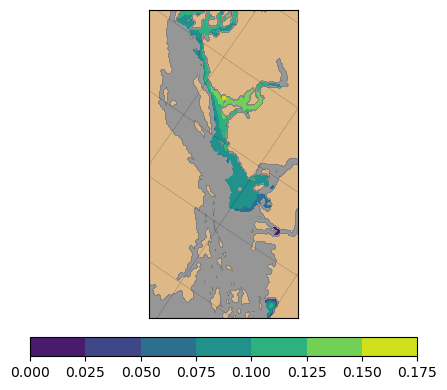

In [15]:
test_f = 'anom_trend_votemper_0to30m_winter.nc'
test_p = 'D:/temp_nemo/trend_output/anom_trend_fromyear/'
test_p = 'D:/temp_nemo/trend_output/anom_trend_frommonth/'
#test_p = 'D:/temp_nemo/trend_output/anom_trend_seasavg/'

# test_f = 'raw_trend_votemper_0to30m_summer.nc'
# test_p = 'D:/temp_nemo/trend_output/raw_trends/'

grid_p = '../data/bathymetry/'
grid_f = 'bathy_salishsea_1500m_20210706.nc'
grid = xr.open_dataset(os.path.join(grid_p, grid_f), mask_and_scale=False)

with nc.Dataset(os.path.join(test_p, test_f)) as test:
#     print(test.variables)
    navlon=test.variables['nav_lon'][:]
    navlat=test.variables['nav_lat'][:]
    slopes=test.variables['slope'][:]
    sig_tf=test.variables['sig_tf'][:]
#     bathy=np.sum(mesh.variables['bathymetry'][0,:])#*mesh.variables['e3t_0'][0,:,:,:],0)


fig, ax = plt.subplots(figsize=(5,5)) #w,h
m = make_map(ax,grid,
             w_map=[-130, -115, 41, 60],
             rotation=43,
             par_inc=0.5,
             mer_inc=1
            )

adjust_map(ax)
slopes = np.ma.masked_where(tmask[0,0,:] == 0, slopes)
slopes = np.ma.masked_where(sig_tf == 0, slopes)
slopes = slopes * 10

x, y = m(navlon, navlat)
c = m.contourf(x, y, slopes, cmap='viridis', shading='auto')
colorbar = plt.colorbar(c, orientation='horizontal', pad=0.05)  
plt.show()

In [151]:
test_f = 'raw_trend_votemper_0to30m_winter.nc'
test_p = 'D:/temp_nemo/trend_output/raw_trends/'


(299, 132)

C:\Users\Greig\AppData\Local\Temp\ipykernel_31532\864692591.py:16: UserWarning: The following kwargs were not used by contour: 'shading'
  c = m.contourf(x, y, slopes, cmap='viridis', shading='auto')


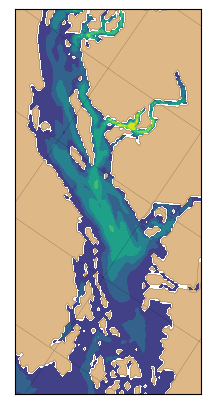

In [134]:
import numpy as np
import pymannkendall as mk
import numpy as np
from scipy.stats import kendalltau

# Generate synthetic weekly temperature data for 40 years
np.random.seed(0)
weeks_per_year = 52
total_weeks = 40 * weeks_per_year
weekly_temperature = np.random.normal(0, 1, total_weeks)

# Calculate annual averages
annual_temperature = np.mean(weekly_temperature.reshape(-1, weeks_per_year), axis=1)

# Perform Mann-Kendall test on the original weekly data
result_weekly = mk.original_test(weekly_temperature)

# Perform Mann-Kendall test on the annual averages
result_annual = mk.original_test(annual_temperature)

print("Mann-Kendall Test on Weekly Data:")
print(f"Trend: {result_weekly.trend}, p-value: {result_weekly.p}")

print("\nMann-Kendall Test on Annual Averages:")
print(f"Trend: {result_annual.trend}, p-value: {result_annual.p}")

# Perform Mann-Kendall test on the original weekly data
tau_weekly, p_weekly = kendalltau(weekly_temperature, range(total_weeks))

# Perform Mann-Kendall test on the annual averages
tau_annual, p_annual = kendalltau(annual_temperature, range(40))

print("Mann-Kendall Test on Weekly Data:")
print(f"Tau: {tau_weekly}, p-value: {p_weekly}")
print()
print("Mann-Kendall Test on Annual Averages:")
print(f"Tau: {tau_annual}, p-value: {p_annual}")

Mann-Kendall Test on Weekly Data:
Trend: no trend, p-value: 0.28598064143147006

Mann-Kendall Test on Annual Averages:
Trend: no trend, p-value: 0.42144237894257297
Mann-Kendall Test on Weekly Data:
Tau: 0.01561031561031561, p-value: 0.2859663659138255

Mann-Kendall Test on Annual Averages:
Tau: 0.08974358974358974, p-value: 0.4147447293562837


In [ ]:
import numpy as np
from scipy.stats import kendalltau

# Generate synthetic weekly temperature data for 40 years
np.random.seed(0)
weeks_per_year = 52
total_weeks = 40 * weeks_per_year
weekly_temperature = np.random.normal(0, 1, total_weeks)

# Calculate annual averages
annual_temperature = np.mean(weekly_temperature.reshape(-1, weeks_per_year), axis=1)

# Perform Mann-Kendall test on the original weekly data
tau_weekly, p_weekly = kendalltau(weekly_temperature, range(total_weeks))

# Perform Mann-Kendall test on the annual averages
tau_annual, p_annual = kendalltau(annual_temperature, range(40))

print("Mann-Kendall Test on Weekly Data:")
print(f"Tau: {tau_weekly}, p-value: {p_weekly}")
print()
print("Mann-Kendall Test on Annual Averages:")
print(f"Tau: {tau_annual}, p-value: {p_annual}")